In [26]:
import pandas as pd
import pandas as pandasForSortingCSV
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout



In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [7]:
df = pd.read_csv("ispu_data.csv", index_col=0)
df.head()

,pm10,so2,co,o3,no2,max,critical,categori,lokasi_spku
tanggal,,,,,,,,,
2019-01-01,29,15,7,71,13,71,O3,SEDANG,DKI2
2019-01-02,24,17,6,79,6,79,O3,SEDANG,DKI2
2019-01-03,23,16,6,65,4,65,O3,SEDANG,DKI2
2019-01-04,42,18,10,64,11,64,O3,SEDANG,DKI2
2019-01-05,54,29,16,51,20,54,PM10,SEDANG,DKI3


In [9]:
df.describe()

,pm10,o3,no2,max
count,1076.000000,1076.000000,1076.000000,1076.000000
mean,61.869888,81.512082,25.739777,98.025093
std,15.001637,38.504181,22.025802,32.307251
min,0.000000,18.000000,3.000000,41.000000
25%,54.000000,53.000000,13.000000,76.000000
50%,63.000000,73.000000,17.000000,92.000000
75%,71.000000,100.000000,32.000000,114.000000
max,179.000000,243.000000,148.000000,243.000000


In [11]:
df_columns = df.columns.tolist()
df_columns

['pm10',
 'so2',
 'co',
 'o3',
 'no2',
 'max',
 'critical',
 'categori',
 'lokasi_spku']

In [13]:
df = df.drop(['so2','co','o3','no2','max','critical','categori','lokasi_spku'], axis=1)
df.head()

,pm10
tanggal,
2019-01-01,29
2019-01-02,24
2019-01-03,23
2019-01-04,42
2019-01-05,54


<AxesSubplot:>

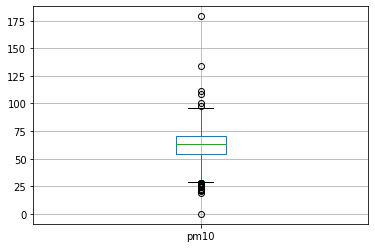

In [14]:
df.boxplot()

In [16]:
# Data Normalization
val = df.values
scale = MinMaxScaler(feature_range=(0,1))
data_norm = scale.fit_transform(val)

In [20]:
data_norm[:2,:]

array([[0.16201117],
       [0.13407821]])

In [22]:
# Window for time serie graph
def win_supervised(train):
    size_window = 4
    x = []
    y = []
    for i in range(size_window, len(train)):
        x.append(train[i - size_window:i, :])
        y.append(train[i, 0:1])
    return x, y

In [23]:
x, y = win_supervised(data_norm)
x = np.array(x)
y = np.array(y)
print('X', x.shape)
print('Y', y.shape)

X (1072, 4, 1)
Y (1072, 1)


In [30]:
# Split dataset
n_train = math.ceil(len(data_norm) * 0.8)
x_train, x_test = x[:n_train,], x[n_train:,]
print('X_train', x_train.shape)
print('X_test', x_test.shape)

y_train, y_test = y[:n_train,], y[n_train:,]
print('Y_train', y_train.shape)
print('Y_test', y_test.shape)


X_train (861, 4, 1)
X_test (211, 4, 1)
Y_train (861, 1)
Y_test (211, 1)


In [31]:
# Model
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')  

In [32]:
#Train Model
model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
27/27 [==============================] - 30s 73ms/step - loss: 0.0385
Epoch 2/20
27/27 [==============================] - 2s 66ms/step - loss: 0.0076
Epoch 3/20
27/27 [==============================] - 2s 69ms/step - loss: 0.0064
Epoch 4/20
27/27 [==============================] - 2s 65ms/step - loss: 0.0065
Epoch 5/20
27/27 [==============================] - 2s 66ms/step - loss: 0.0063
Epoch 6/20
27/27 [==============================] - 2s 70ms/step - loss: 0.0061
Epoch 7/20
27/27 [==============================] - 2s 71ms/step - loss: 0.0059
Epoch 8/20
27/27 [==============================] - 2s 71ms/step - loss: 0.0060
Epoch 9/20
27/27 [==============================] - 2s 67ms/step - loss: 0.0061
Epoch 10/20
27/27 [==============================] - 2s 71ms/step - loss: 0.0062
Epoch 11/20
27/27 [==============================] - 2s 68ms/step - loss: 0.0058
Epoch 12/20
27/27 [==============================] - 2s 85ms/step - loss: 0.0058
Epoch 13/20
27/27 [=================

In [47]:
# Try for Prediction
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

7/7 [==============================] - 0s 27ms/step


0.08600083144288283

In [48]:
# Shape each
print('Y_Predicted', y_pred.shape)
print('X_Test', x_test.shape)
print('Scaled Values(Normalization Data)', data_norm.shape)

Y_Predicted (211, 1)
X_Test (211, 4, 1)
Scaled Values(Normalization Data) (1076, 1)


In [49]:
# Scale back to original
org = data_norm[:211,:]
print('Shape org', org.shape)
print('y_pred', y_pred.shape)
y_pred = np.concatenate((y_pred, org[:211,1:]), axis=1)
print('concat y_pred', y_pred.shape)
y_tested = np.concatenate((y_test, org[:211,1:]), axis=1)
print('concat y_test', y_test.shape)

Shape org (211, 1)
y_pred (211, 1)
concat y_pred (211, 1)
concat y_test (211, 1)


In [50]:
# Inverse data
y_pred = scale.inverse_transform(y_pred)
y_tested = scale.inverse_transform(y_tested)
y_pred = y_pred[:,0:1]
y_tested = y_tested[:,0:1]
print('y_tested', y_tested.shape)
print('y_predicted', y_pred.shape)

y_tested (211, 1)
y_predicted (211, 1)


In [51]:
# Calculate Error
mse = mean_squared_error(y_tested, y_pred)
rmse = np.sqrt(mse)
rmse

15.394148828276025

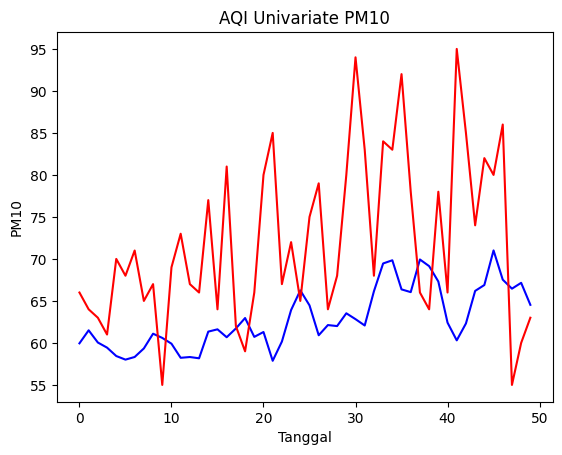

In [54]:
# Plot Prediction vs Original Data
plt.plot(y_pred[:50,:], color= 'blue')
plt.plot(y_tested[:50,:] , color = 'red')
plt.title("AQI Univariate PM10")
plt.xlabel("Tanggal")
plt.ylabel("PM10")
plt.show()

In [63]:
train = df[:n_train]
print(n_train)
validation = y_tested
validation['Predictions'] = y_pred

plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Tingkat PM10', fontsize=18)
plt.plot(train['pm10'])
plt.plot(validation[['pm10', 'Predictions']])
plt.legend(['Train', 'Val', 'Prediction'], loc='lower right')
plt.show()

861


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices